In [1]:
import random
import gym
import numpy as np
import random
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
from sklearn.preprocessing import StandardScaler
import random
# Normalize features
from sklearn.preprocessing import StandardScaler
from collections import deque
import torch.nn.functional as F
import random
import gym
import numpy as np
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/kaggle/input/eqqerff/preprocessed.csv')
data.drop(columns= ['Unnamed: 0','index'], inplace = True)
# preprocessing
data['DATETIME'] = pd.to_datetime(data['DATETIME'])
data['TIME'] = data['TIME'].astype(str).str.rstrip('000')
data['hour'] = data['DATETIME'].dt.hour
data['minute'] = data['DATETIME'].dt.minute
data['day_of_week'] = data['DATETIME'].dt.day_name()
data['second'] =  data['DATETIME'].dt.second
day_map = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5, 'Sunday': 6}
data['day_of_week'] = data['day_of_week'].map(day_map)
data.drop(columns= ['DATETIME','TIME'], inplace = True) 
data.drop(columns= ['TRADE_PRICE','TRADENO'], inplace = True)
data= data.dropna()
data.drop(columns = ['DATE', 'ACTION','ORDERNO','TRADE_TIME'], inplace = True)
# Create a dictionary to map string values to numeric values
buysell_map = {'B': 0, 'S': 1}

# Map the string values to numeric values
data['BUYSELL'] = data['BUYSELL'].map(buysell_map)
data.drop(columns = 'TRADEPRICE', inplace = True)

In [3]:
from tqdm import tqdm
# Normalizing the data
def normalize_data(df):
    df_normalized = df.copy()
    for column in df.columns:
        if df[column].dtype == np.float64 or df[column].dtype == np.int64:
            df_normalized[column] = (df[column] - df[column].mean()) / df[column].std()
    return df_normalized

data = normalize_data(data)

In [4]:
#def reward_function(df):
 #   # Calculate best bid-ask spread for each date
  #  best_spread_per_date = df.groupby('DATE').apply(lambda x: x['BID_PRICE'].max() - x['ASK_PRICE'].min())

    #rewards = []
    #for index, row in df.iterrows():
        # Calculate execution price deviation from best bid-ask spread
       # execution_price_deviation = row['PRICE'] - best_spread_per_date[row['DATE']]

        # Calculate execution speed penalty
       # execution_speed_penalty = 100 / 1000  # converting milliseconds to seconds

      #  # Calculate commission cost
       # commission_cost = 0.01 * row['TRADE_VOLUME']
       # # Calculate market impact penalty (quadratic function)
       # market_impact_penalty = 0.0001 * (row['TRADE_VOLUME'] ** 2)

        # Calculate total reward
        #reward = -execution_price_deviation - execution_speed_penalty -  commission_cost- market_impact_penalty
        #rewards.append(reward)

   # return rewards
#
# rewards = reward_function(data)

100%|██████████| 500/500 [01:04<00:00,  7.80it/s]


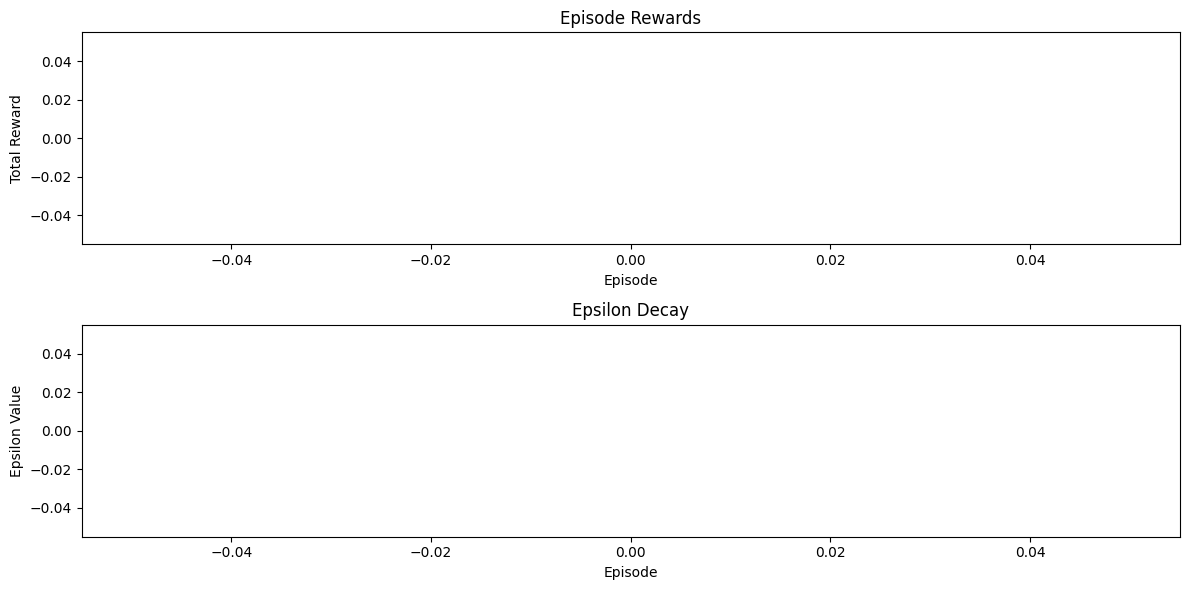

In [5]:
# Normalise function
def normalise(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Hyperparameters
EPISODES = 500
MEMORY = 100000
INITIAL_INVENTORY = 21
INITIAL_INVENTORY_SCALED = 1
TIME_CONSTRAINT_FOR_EXECUTION = 11
A = 0.01

TRAINING = True
TRAIN_BOUNDARIES = False
LOAD_PRETRAINED_WEIGHTS = False

PANDL_REWARD = False
EGREEDY = "Binomial"
NN = "NN=6_NN"
OPTIMIZER = 'RMSprop'
FILENAME = f"DDQN{EPISODES}_NN_{EGREEDY}_A={A}_Actions={INITIAL_INVENTORY}_TimeConstr={TIME_CONSTRAINT_FOR_EXECUTION}_Opt={OPTIMIZER}_REW={str(PANDL_REWARD)}"
STATE_SIZE = 2
BATCH_SIZE = 64

# Define TIME_POINTS_FOR_EXECUTION
TIME_POINTS_FOR_EXECUTION = TIME_CONSTRAINT_FOR_EXECUTION

# Splitting the data
TRAIN_OBSERVATIONS = int(0.7 * len(data))
if TRAINING:
    DF = data.iloc[:TRAIN_OBSERVATIONS, ]
    REAL_TIME = 0
    END_TIME = len(DF)
else:
    DF = data.iloc[TRAIN_OBSERVATIONS:, ]
    REAL_TIME = TRAIN_OBSERVATIONS
    END_TIME = TRAIN_OBSERVATIONS + len(DF)
    EPISODES = 34

PRICES = np.array(DF['PRICE'].to_numpy())
PRICES = normalise(PRICES)

# Environment Class
class Env:
    def __init__(self, state, prices, time_constraint_for_execution, time_points_for_execution, real_time, end_time):
        self.state = state
        self.prices = prices
        self.time_constraint_for_execution = time_constraint_for_execution
        self.time_points_for_execution = time_points_for_execution
        self.real_time = real_time
        self.end_time = end_time

    def reset_game(self):
        self.state.inventory = INITIAL_INVENTORY_SCALED
        self.state.time = 0
        return self.state

    def step(self, action):
        reward = self.reward(self.state.inventory, action)
        self.state.time = round(self.state.time + 1 / (self.time_points_for_execution - 1), 2)
        self.real_time = (self.real_time + 1) if (self.real_time + 1) % self.end_time != 0 else REAL_TIME
        self.state.inventory = round(self.state.inventory - action, 2)
        return self.state, reward, self.is_done()

    def is_done(self):
        return self.state.time == self.time_constraint_for_execution

    def get_price(self):
        return self.prices[self.real_time - REAL_TIME]

    def reward(self, remaining_inventory, action):
        if PANDL_REWARD:
            return action * self.get_price() - 2.5 * (action ** 2)
        return remaining_inventory * (self.get_price() - self.get_price()) - A * (action ** 2)

    def PandL(self, action):
        return action * self.get_price() - A * (action ** 2)

class State:
    def __init__(self, time, inventory):
        self.time = time
        self.inventory = inventory

    def state_as_list(self):
        return [self.time, self.inventory]

class TWAP:
    def __init__(self, initial_inventory, time_points_for_execution):
        self.initial_inventory = initial_inventory
        self.time_points_for_execution = time_points_for_execution

    def act(self):
        return self.initial_inventory / self.time_points_for_execution

# DQN Agent Class
class DQNAgent:
    def __init__(self, state_size, action_size, TRAINING):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MEMORY)
        self.gamma = 0.99
        self.epsilon = 1.0 if TRAINING else 0.0
        self.epsilon_min = 0.01 if TRAINING else 0.0
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model, self.optimizer = self._build_model()
        self.target_model, _ = self._build_model()
        self.update_target_model()

    def _build_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_size, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, 20),
            nn.ReLU(),
            nn.Linear(20, self.action_size)  # Corrected the final layer
        )
        optimizer = optim.RMSprop(model.parameters(), lr=self.learning_rate)
        return model, optimizer

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state, time, time_constraint_for_execution):
        inventory = state[0][1]

        if time == (time_constraint_for_execution - 1 / (TIME_POINTS_FOR_EXECUTION - 1)):
            action = inventory
        elif inventory == 0:
            action = 0
        elif np.random.rand() <= self.epsilon:
            if EGREEDY == 'Binomial':
                n = inventory * INITIAL_INVENTORY
                p = 1 / (TIME_POINTS_FOR_EXECUTION - time)
                action = np.random.binomial(n, p) / INITIAL_INVENTORY
            elif EGREEDY == 'Uniform':
                action = random.randrange(self.action_size) / INITIAL_INVENTORY
        else:
            state_tensor = torch.FloatTensor(state)
            with torch.no_grad():
                act_values = self.model(state_tensor)
            action = np.argmax(act_values[0].numpy()) / (INITIAL_INVENTORY - 1)

        if action > inventory:
            action = inventory
        return round(action, 2)

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            
            # Normalize action to ensure it's within [0, 1]
            action = np.clip(action, 0.0, 1.0)
            
            # Find action index in action_range
            action_range = np.linspace(0, 1, self.action_size)
            action_index = np.abs(action_range - action).argmin()
            
            # Compute Q-value target
            target = self.model(state_tensor)
            
            if done:
                target[0, action_index] = reward
            else:
                with torch.no_grad():
                    t = self.target_model(next_state_tensor).max(1)[0]
                target[0, action_index] = reward + self.gamma * t.item()
            
            self.model.train()
            self.optimizer.zero_grad()
            loss = nn.MSELoss()(self.model(state_tensor), target)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_state_dict(torch.load(name))

    def save(self, name):
        torch.save(self.model.state_dict(), name)

# Training Loop
state_size = STATE_SIZE
action_size = INITIAL_INVENTORY

agent = DQNAgent(state_size, action_size, TRAINING)
twap = TWAP(INITIAL_INVENTORY_SCALED, TIME_CONSTRAINT_FOR_EXECUTION)
env = Env(State(0, INITIAL_INVENTORY_SCALED), PRICES, TIME_CONSTRAINT_FOR_EXECUTION, TIME_POINTS_FOR_EXECUTION, REAL_TIME, END_TIME)

episode_rewards = []
epsilon_values = []

for episode in tqdm(range(EPISODES)):
    state = env.reset_game().state_as_list()
    state = np.reshape(state, [1, state_size])

    total_reward = 0

    for time in range(TIME_POINTS_FOR_EXECUTION):
        action = agent.act(state, time, TIME_CONSTRAINT_FOR_EXECUTION)
        next_state, reward, done = env.step(action)
        next_state = np.reshape(next_state.state_as_list(), [1, state_size])
        total_reward += reward

        agent.remember(state, action, reward, next_state, done)
        state = next_state

        if TRAIN_BOUNDARIES:
            agent.replay(BATCH_SIZE)

        if done:
            episode_rewards.append(total_reward)
            epsilon_values.append(agent.epsilon)
            tqdm.write(f"Episode: {episode + 1}/{EPISODES}, Score: {total_reward:.2f}, Epsilon: {agent.epsilon:.2f}")
            break

    if not TRAIN_BOUNDARIES:
        agent.replay(BATCH_SIZE)

    agent.update_target_model()

# Plotting results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(2, 1, 2)
plt.plot(epsilon_values)
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')

plt.tight_layout()
plt.show()


  0%|          | 0/500 [00:00<?, ?it/s]/tmp/ipykernel_24/2287280505.py:81: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  state_batch = torch.FloatTensor(state_batch)
100%|██████████| 500/500 [01:28<00:00,  5.66it/s]


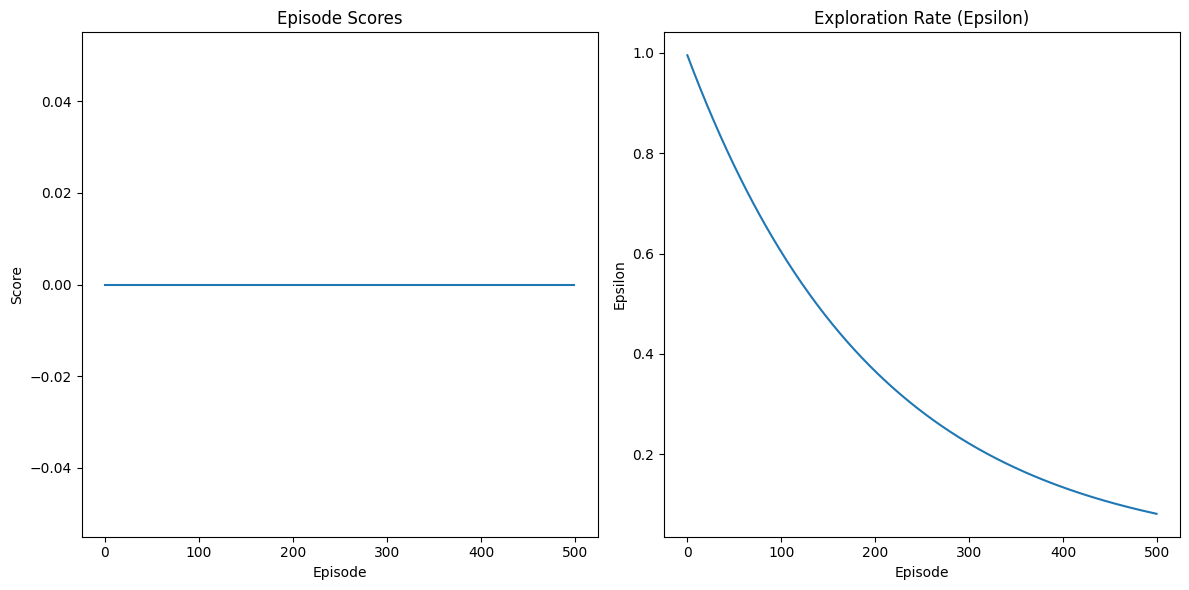

In [6]:
# Define constants and hyperparameters
EPISODES = 500   # Number of episodes for training
BATCH_SIZE = 32  # Batch size for replay buffer
GAMMA = 0.99     # Discount factor for future rewards
EPSILON_START = 1.0  # Initial exploration rate
EPSILON_END = 0.01   # Final exploration rate
EPSILON_DECAY = 0.995  # Decay rate of exploration rate
MEMORY_CAPACITY = 10000  # Replay memory capacity

class Env:
    def __init__(self, initial_state):
        self.state = initial_state
        self.max_steps = 100  # Define maximum steps per episode (adjust as needed)
        self.current_step = 0  # Track current step within an episode
    
    def reset(self):
        # Reset environment to initial state
        self.state = np.zeros_like(self.state)  # Replace with actual initial state setup
        self.current_step = 0
        return self.state
    
    def step(self, action):
        # Implement step function to take action and return next_state, reward, done
        # Example: Update state based on action, calculate reward, check termination condition
        next_state = self.state  # Placeholder implementation, replace as per your logic
        reward = 0  # Placeholder reward
        done = False  # Placeholder done flag
        self.current_step += 1
        
        # Implement your environment dynamics here
        
        if self.current_step >= self.max_steps:
            done = True
        
        return next_state, reward, done

# Define your DQN agent class (replace with your actual implementation)
class DQNAgent:
    def __init__(self, state_size, action_size, training=True):
        self.state_size = state_size
        self.action_size = action_size
        self.training = training
        self.memory = []
        self.epsilon = EPSILON_START
        
        # Define neural network model
        self.model = nn.Sequential(
            nn.Linear(state_size, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, action_size)
        )
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
    def act(self, state):
        # Epsilon-greedy policy to choose action
        if self.training and random.random() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
            return q_values.max(1)[1].item()
    
    def remember(self, state, action, reward, next_state, done):
        # Store experience in replay memory
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > MEMORY_CAPACITY:
            del self.memory[0]
    
    def replay(self, batch_size):
        # Experience replay to update Q-network
        if len(self.memory) < batch_size:
            return
        
        minibatch = random.sample(self.memory, batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*minibatch)
        
        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch)
        reward_batch = torch.FloatTensor(reward_batch)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch)
        
        current_q_values = self.model(state_batch).gather(1, action_batch.unsqueeze(1))
        next_q_values = self.model(next_state_batch).max(1)[0].detach()
        target_q_values = reward_batch + (1 - done_batch) * GAMMA * next_q_values
        
        loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def adaptive_epsilon_decay(self):
        # Decay exploration rate epsilon
        if self.epsilon > EPSILON_END:
            self.epsilon *= EPSILON_DECAY

# Main training loop
def train(env, agent, episodes):
    scores = []  # List to store scores from each episode
    epsilon_values = []  # List to store epsilon values over time
    
    for episode in tqdm(range(episodes)):
        state = env.reset()  # Reset environment for new episode
        total_reward = 0
        
        while True:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay(BATCH_SIZE)
            
            total_reward += reward
            state = next_state
            
            if done:
                break
        
        agent.adaptive_epsilon_decay()
        scores.append(total_reward)
        epsilon_values.append(agent.epsilon)
    
    return scores, epsilon_values

# Example initialization and training
# Replace with your actual state_size, action_size, and initial_state setup
state_size = 4  # Replace with your state size
action_size = 2  # Replace with your action size
initial_state = np.zeros(state_size)  # Replace with actual initial state

# Initialize environment and agent
env = Env(initial_state)
agent = DQNAgent(state_size, action_size)

# Train the agent
scores, epsilon_values = train(env, agent, EPISODES)

# Plotting results
plt.figure(figsize=(12, 6))

# Plot scores
plt.subplot(1, 2, 1)
plt.plot(scores)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Episode Scores')

# Plot epsilon values
plt.subplot(1, 2, 2)
plt.plot(epsilon_values)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Exploration Rate (Epsilon)')

plt.tight_layout()
plt.show()
